# An experiment of "fitted lerning" 

Notes:

the original paper  
https://arxiv.org/abs/1609.02226

In the following, settings closely follow  
https://github.com/yhenon/fitted-learning

In [1]:
import chainer
from chainer import functions as F
from chainer import links as L
from chainer import Chain
from chainer import training, iterators, optimizers
from chainer.datasets import TupleDataset
from chainer.training import extensions
from chainer import cuda

In [2]:
from PIL import Image, ImageDraw

In [3]:
import numpy as np

In [4]:
uses_device = 0
if uses_device >= 0:
    cuda.get_device_from_id(0).use()
    cuda.check_cuda_available()
    import cupy as cp
else:
    cp = np

# Train Data

In [5]:
def generate_circles(radii, n_points):
    """
    This function generates points of circles.
    
    Input 
        radii    : a list of three radii of the circles
                   The number of elements must be three corresponding to RGB which will be displayed later.
        n_points : the number of points generated per radius
    Outpot
        tuple of numpy array : (points of cordinates, labels corresponding to radii)
                               label 'i' corresponds to radii[i]
    """
    
    if len(radii) != 3:
        raise Exception("len(radii) must be 3")
    
    angles = np.linspace(0, 2*np.pi, n_points)

    X = np.array([])
    Y = np.array([])
    T = np.array([])

    x1 = np.cos(angles)
    y1 = np.sin(angles)
    
    label = 0
    for r in radii:
        xr = r * x1
        yr = r * y1
        tr = np.array([label] * n_points)
        X = np.append(X, xr)
        Y = np.append(Y, yr)
        T = np.append(T, tr)
        label += 1
        
    n_elements = X.shape[0]
    X = X.reshape(1, n_elements)
    Y = Y.reshape(1, n_elements)
    P = np.concatenate([X, Y]).transpose()
    
    return P.astype(np.float32), T.astype(np.int32)

In [6]:
#use in NN-class
def convert_onehot(labels_arr):
    """
    This function converts labels to one-hot representation.
    Used in NN classes.
    
    Input 
        labels_arr : array of labels
    Output
        numpy or cupy array of one-hot represented labels
    """
    target = labels_arr.flatten()
    n_labels = int(cp.max(target) + 1)
    return cp.eye(n_labels, dtype=cp.float32)[target]

In [7]:
#use in NN-class
def duplicate_DOO(in_arr, DOO):
    """
    This function duplicates input array by DOO in the direction of axis=1, and then divides them by DOO.
    Used in NN clases.
    
    Input 
        in_arr : array of one-hot represented labels
        DOO    : an integer representing competing nuerons in one aggregate (Degree Of Overcomletenes)  
    Output
        numpy or cupy array of duplicated representation
    """
    batch_size = in_arr.shape[0]
    arr_org = in_arr.reshape(batch_size, -1)
    length = arr_org.shape[1]
    
    arr = cp.empty((batch_size, 0), dtype=cp.int32)
    for i in range(length):
        col = arr_org[:,i].reshape(batch_size, -1)
        for _ in range(DOO):
            arr = cp.concatenate((arr, col), axis=1)
    
    return arr.astype(cp.float32) / DOO

## genarate data 

In [8]:
radii = [0.25, 0.5, 1.0]
n_classes = len(radii)
n_points = 10000

In [9]:
P, T = generate_circles(radii, n_points)
if uses_device >= 0:
    P = cuda.to_gpu(P)
    T = cuda.to_gpu(T)
train = TupleDataset(P, T)

# models 

## Simple Nueral Net models

SimpleNN  
 -> The most simple Neural model of this experiment, including only liner transformation, relu and softmax.
 
SimpleNN_v2  
 -> Drop out layers are added as the most simple example of ensamble laerning.

In [10]:
class SimpleNN(Chain):
    
    def __init__(self):
        super(SimpleNN, self).__init__()
        with self.init_scope():
            self.l1 = L.Linear(2, 64)
            self.l2 = L.Linear(64, 128)
            self.l3 = L.Linear(128, 128)
            self.l4 = L.Linear(128, 128)
            self.l5 = L.Linear(128, 3)
            
    def __call__(self, x, t=None, train=True):
        h1 = F.relu(self.l1(x))
        h2 = F.relu(self.l2(h1))
        h3 = F.relu(self.l3(h2))
        h4 = F.relu(self.l4(h3))
        h5 = self.l5(h4)
        return F.softmax_cross_entropy(h5, t) if train else F.softmax(h5)        

In [11]:
class SimpleNN_v2(Chain):
    
    def __init__(self):
        super(SimpleNN_v2, self).__init__()
        with self.init_scope():
            self.l1 = L.Linear(2, 64)
            self.l2 = L.Linear(64, 128)
            self.l3 = L.Linear(128, 128)
            self.l4 = L.Linear(128, 128)
            self.l5 = L.Linear(128, 3)
           
        
    def foward(self, x):
        h1 = F.dropout(F.relu(self.l1(x)), ratio=0.2)
        h2 = F.dropout(F.relu(self.l2(h1)), ratio=0.2)
        h3 = F.dropout(F.relu(self.l3(h2)), ratio=0.2)
        h4 = F.dropout(F.relu(self.l4(h3)), ratio=0.2)
        h5 = F.dropout(self.l5(h4), ratio=0.2)
        return h5
        
        
    def __call__(self, x, t=None, train=True):
        if train:
            with chainer.using_config('train', True):
                h5 = self.foward(x)
            return F.softmax_cross_entropy(h5, t)
        
        else:
            with chainer.using_config('train', False):
                h5 = self.foward(x)
            return F.softmax(h5)

## Cool Nueral Net models 

CoolNN_v1  
 -> I think this model is naive implementation of the paper.
 
     In the last layer, 
      1. take softmax for each nueron aggregate 
      2. combine an aggregate through multiplication
          => trained with this output
          
    This implementation seems not to work properly.
    See the Results below.


CoolNN_v2  
 -> Implementation in https://github.com/yhenon/fitted-learning
 
     In the last layer, 
      1. take softmax among all neuron units
          => trained with this output
      2. combine an aggregate through multiplication
   
    This implementation seems to work properly.


CoolNN_v3  
 -> Intermediate model between v1 and v2
 
     In the last layer, 
      1. take softmax for each nueron aggregate 
          => trained with this output
      2. combine an aggregate through multiplication

    This implementation does not work at all.
    The reason may be that uniform distribution is learned at each aggregate.

In [29]:
class CoolNN_v1(Chain):
    
    def __init__(self, DOO):
        super(CoolNN_v1, self).__init__()
        self.DOO = DOO
        
        with self.init_scope():
            self.l1 = L.Linear(2, 64)
            self.l2 = L.Linear(64, 128)
            self.l3 = L.Linear(128, 128)
            self.l4 = L.Linear(128, 128)
            
            self.lc0 = L.Linear(128, DOO)
            self.lc1 = L.Linear(128, DOO)
            self.lc2 = L.Linear(128, DOO)
            
            
    def __call__(self, x, t=None, train=True):
        h1 = F.relu(self.l1(x))
        h2 = F.relu(self.l2(h1))
        h3 = F.relu(self.l3(h2))
        h4 = F.relu(self.l4(h3))
        
        p0 = F.prod(self.DOO * F.softmax(self.lc0(h4)), axis=1)
        p1 = F.prod(self.DOO * F.softmax(self.lc1(h4)), axis=1)
        p2 = F.prod(self.DOO * F.softmax(self.lc2(h4)), axis=1)
        
        p = [p0, p1, p2]
        
        if train:
            t = convert_onehot(t)
            if len(p) != t.shape[1]:
                raise Exception("number of labels unmatched")
                
            n_labels = len(p)
            loss = 0
            for i in range(n_labels):
                #loss -= F.sum(t[:,i] * F.log(1+p[i]) + (1 - t[:,i]) * F.log(1+1 - p[i])) # do not work
                loss += F.mean_squared_error(p[i], t[:,i])
                #loss += F.mean_absolute_error(p[i], t[:,i]) # do not work
            #print(loss.data)
            return loss
        
        else:
            return F.concat((p0.reshape(-1,1), p1.reshape(-1, 1), p2.reshape(-1, 1)), axis=1)
        

In [13]:
class CoolNN_v2(Chain):
    
    def __init__(self, DOO):
        super(CoolNN_v2, self).__init__()
        self.DOO = DOO
        
        with self.init_scope():
            self.l1 = L.Linear(2, 64)
            self.l2 = L.Linear(64, 128)
            self.l3 = L.Linear(128, 128)
            self.l4 = L.Linear(128, 128)
            
            self.lc0 = L.Linear(128, self.DOO)
            self.lc1 = L.Linear(128, self.DOO)
            self.lc2 = L.Linear(128, self.DOO)
        
        
    def __call__(self, x, t=None, train=True):
        h1 = F.relu(self.l1(x))
        h2 = F.relu(self.l2(h1))
        h3 = F.relu(self.l3(h2))
        h4 = F.relu(self.l4(h3))
        
        hc0 = self.lc0(h4)
        hc1 = self.lc1(h4)
        hc2 = self.lc2(h4)
        
        h5 = F.concat((hc0, hc1, hc2), axis=1)
        p = F.softmax(h5)
        
        if train:
            t = convert_onehot(t)
            t = duplicate_DOO(t, self.DOO)
            loss = -F.sum(t * F.log(p))
            #print(loss.data)
            return loss
            
        else:
            
            p0 = F.prod(self.DOO * p[:,0:self.DOO], axis=1).reshape(-1,1)
            p1 = F.prod(self.DOO * p[:,self.DOO:2*self.DOO], axis=1).reshape(-1,1)
            p2 = F.prod(self.DOO * p[:,2*self.DOO:3*self.DOO], axis=1).reshape(-1,1)
            return F.concat((p0, p1, p2), axis=1) 
            

In [14]:
class CoolNN_v3(Chain):
    
    def __init__(self, DOO):
        super(CoolNN_v3, self).__init__()
        self.DOO = DOO
        
        with self.init_scope():
            self.l1 = L.Linear(2, 64)
            self.l2 = L.Linear(64, 128)
            self.l3 = L.Linear(128, 128)
            self.l4 = L.Linear(128, 128)
            
            self.lc0 = L.Linear(128, self.DOO)
            self.lc1 = L.Linear(128, self.DOO)
            self.lc2 = L.Linear(128, self.DOO)
        
        
    def __call__(self, x, t=None, train=True):
        h1 = F.relu(self.l1(x))
        h2 = F.relu(self.l2(h1))
        h3 = F.relu(self.l3(h2))
        h4 = F.relu(self.l4(h3))
        
        hc0 = self.lc0(h4)
        hc1 = self.lc1(h4)
        hc2 = self.lc2(h4)
        
        pc0 = F.softmax(hc0)
        pc1 = F.softmax(hc1)
        pc2 = F.softmax(hc2)
        
        
        if train:
            p = F.concat((pc0, pc1, pc2), axis=1)
            t = convert_onehot(t)
            t = duplicate_DOO(t, self.DOO)
            #loss = -F.sum(t * F.log(p))
            loss = F.mean_squared_error(t, p)
            #print(loss)
            return loss
            
        else:
            
            p0 = F.prod(self.DOO*pc0, axis=1).reshape(-1,1)
            p1 = F.prod(self.DOO*pc1, axis=1).reshape(-1,1)
            p2 = F.prod(self.DOO*pc2, axis=1).reshape(-1,1)
            return F.concat((p0, p1, p2), axis=1) 
            

## function to draw image

In [15]:
def draw_result(model):
    """
    This function shows the decision boudaries of the model.
    
    Input 
        model : trained model
    Output
        Image of the decision boundaries
    
    global variable
        radii
    """
    
    x_min, x_max = -2, 2
    y_min, y_max = x_min, x_max
    h = 0.01
    
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    grid_points = np.c_[xx.flatten(), yy.flatten()].astype(np.float32)
    if uses_device >= 0:
        grid_points = cuda.to_gpu(grid_points) 
        
    res = model(grid_points, train=False).data
    res = cuda.to_cpu(res)
    res = res.reshape(xx.shape + (3, ))
    img = Image.fromarray((255 * res).astype(np.uint8))

    draw = ImageDraw.Draw(img)
    unit_pix = img.size[0] / (x_max - x_min)
    
    for r in radii:
        d = r * unit_pix
        draw.ellipse((200-d, 200-d, 200+d, 200+d), outline=(255, 255, 255))
     
    return img

# Experiments

In [30]:
DOO = 40
#model = SimpleNN_v2()
model = CoolNN_v1(DOO)
if uses_device >= 0:
    model.to_gpu()

In [31]:
batch_size = 500
train_iter = iterators.SerialIterator(train, batch_size=batch_size, shuffle=True)

In [32]:
optimizer = optimizers.Adam()
optimizer.setup(model)

In [33]:
n_epoch = 20
updater = training.StandardUpdater(train_iter, optimizer, device=uses_device)
trainer = training.Trainer(updater, (n_epoch, 'epoch'), out='result')
trainer.extend(extensions.ProgressBar())

In [ ]:
#trainer.extend(extensions.LogReport())
#trainer.extend(extensions.PrintReport( entries=['epoch', 'main/loss']))

In [34]:
trainer.run()

     total [####..............................................]  8.33%
this epoch [#################################.................] 66.67%
       100 iter, 1 epoch / 20 epochs
       inf iters/sec. Estimated time to finish: 0:00:00.
     total [########..........................................] 16.67%
this epoch [################..................................] 33.33%
       200 iter, 3 epoch / 20 epochs
    23.531 iters/sec. Estimated time to finish: 0:00:42.497241.
     total [############......................................] 25.00%
this epoch [..................................................]  0.00%
       300 iter, 5 epoch / 20 epochs
    23.555 iters/sec. Estimated time to finish: 0:00:38.209174.
     total [################..................................] 33.33%
this epoch [#################################.................] 66.67%
       400 iter, 6 epoch / 20 epochs
    23.595 iters/sec. Estimated time to finish: 0:00:33.905240.
     total [####################...

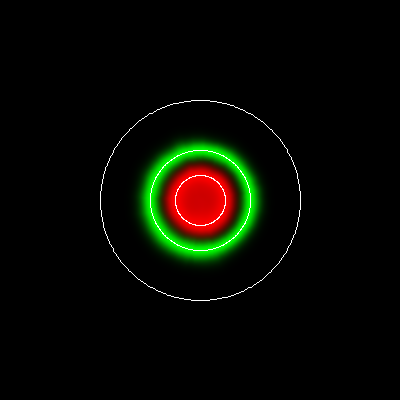

In [35]:
draw_result(model)

# Results

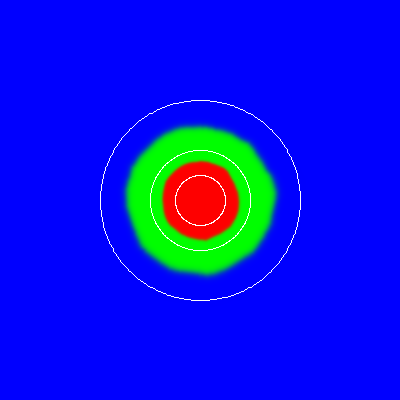

In [72]:
#SimpleNN
draw_result(model)

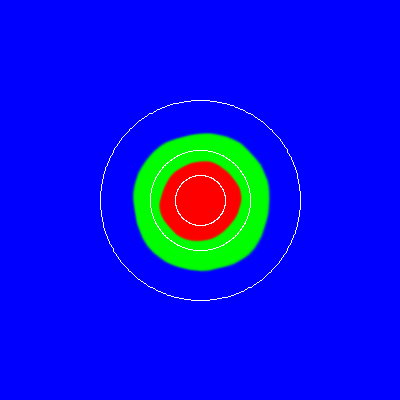

In [78]:
#SimpleNN_v2 (drop out)
draw_result(model)

Simpe Nueral Net models assign confident labels even if the input-data is not similar to the trainin data.

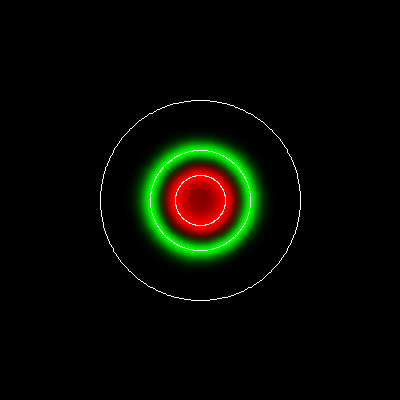

In [58]:
#CoolNN_v1 (soft max per class -> prod)
draw_result(model)

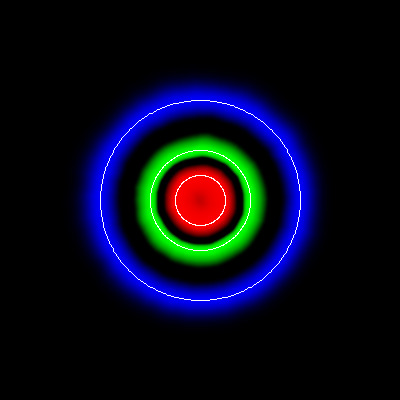

In [66]:
# CoolNN_v2 (soft max among all classes)
draw_result(model)

CoolNN models can assign no label for unseen data,  
except for neighborhoods of the origin which recognized as a part of the red circle (radius=0.25).

Compared to CoolNN_v2, the sesolution of CoolNN_v1 seems to be fine.  
In other words, the green ring is thin and the density around the origin is low.  
But I do not know why, the blue ring (radius=1) is not learned in CoolNN_v1.  
What happend ?? 